# Plan of the notebook:
0. Imports
1. Analysis of the text dataset
2. Text processing and Transformation
3. Embeddding techniques
4. Classification
5. Conclusion

# Data 
> **sources**: [Kaggle Hackathon link](https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018?) ,[Data set origin's publication](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29)<br/>

We have 2 csv files : 
* drugsComTest_raw.csv: 
* drugsComTrain_raw.csv

# 0. Imports 

In [244]:
import time
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, plot_importance

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


import warnings; warnings.simplefilter('ignore')

import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from collections import defaultdict 

# 1. Analysis of the text dataset 


## About the dataset : 
The *UCI ML Drug Review dataset* provides patient reviews on specific drugs along with related conditions and a 10-star patient rating system reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. This data was published in a study on sentiment analysis of drug experience over multiple facets, ex. sentiments learned on specific aspects such as effectiveness and side effects

### Attribute Information:
1. **drugName (categorical)**: name of drug
2. **condition (categorical)**: name of condition
3. **review (text)**: patient review
4. **rating (numerical)**: 10 star patient rating
5. **date (date)**: date of review entry
6. **usefulCount (numerical)**: number of users who found review useful

In [6]:
train_set = pd.read_csv('dataset/drugsComTrain_raw.csv')
test_set = pd.read_csv('dataset/drugsComTest_raw.csv')
train_set

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79


In [7]:
test_set

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20


## 1.1 Descriptive statistics: 

As the 2 datasets have the same columns, we can combine them in order to have a better view on the data 

In [8]:
data_global = pd.concat([train_set, test_set])

In [42]:
data_global.describe()[["usefulCount","rating"]]

,usefulCount,rating
count,215063.000000,215063.000000
mean,28.001004,6.990008
std,36.346069,3.275554
min,0.000000,1.000000
25%,6.000000,5.000000
50%,16.000000,8.000000
75%,36.000000,10.000000
max,1291.000000,10.000000


In [10]:
data_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 13.1+ MB


- As we can see the data here is already clean, indeed we don't have Null values in any column of our dataset, Let's deep dive on the review attribute.

## 1.2 Visualization on `review` attribute:

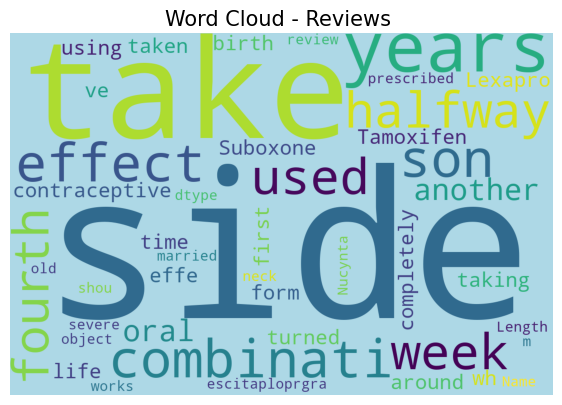

In [45]:
# let's see the words cloud for the reviews 

# most popular drugs

stopwords = STOPWORDS

wordcloud = WordCloud(background_color = 'lightblue', stopwords = stopwords, width = 1200, height = 800).generate(str(data_global['review']))

plt.rcParams['figure.figsize'] = (7, 7)
plt.title('Word Cloud - Reviews ', fontsize = 15)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

## 1.3 Visualization on `rating` attribute :

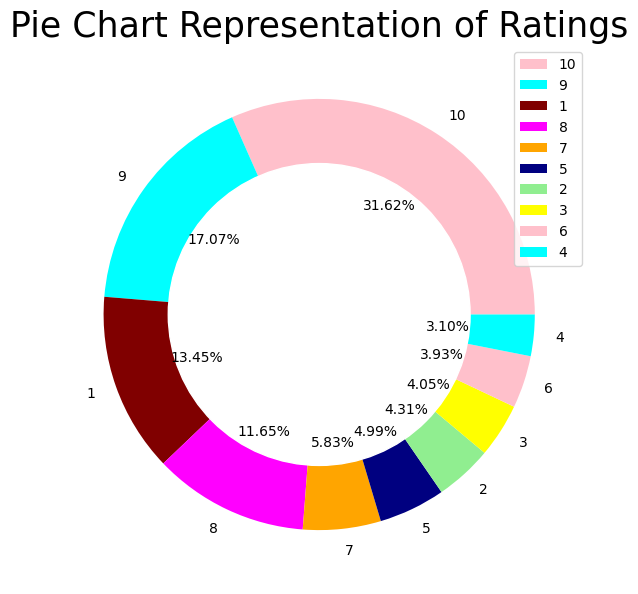

In [12]:
# making a donut chart to represent share of each ratings

size = data_global['rating'].value_counts().to_list()
colors = ['pink', 'cyan', 'maroon',  'magenta', 'orange', 'navy', 'lightgreen', 'yellow']
labels = data_global['rating'].value_counts().index.to_list()

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart Representation of Ratings', fontsize = 25)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

- We can see that there is more **"positif"** rating values than **"negatif"** rating values, 
- The pie Chart illustrates that people generally write reviews for drugs they really like (or those that they really dislike).
<br/> There are fewer middle ratings as compared to extreme ratings

## Is rating correlated with usefulness of the review?

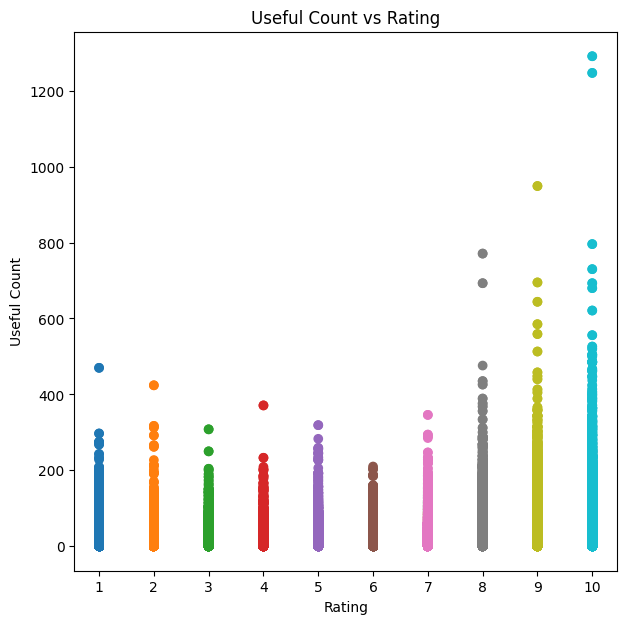

In [13]:
plt.scatter(data_global.rating, data_global.usefulCount, c=data_global.rating.values, cmap='tab10')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.xticks([i for i in range(1, 11)]);

> We can see that people found reviews with higher scores to be more useful! <br/>In the sense that reviews with high ratings recieved more 'useful' tags than reviews with low ratings.

# 2. Text processing and Transformation:

- As we can see below the `review` column is not preprocessed, the next step is to process all reviews :

In [46]:
# First 3 review of the  data_global dataset: 
for i in data_global.review.iloc[:3]:
    print(i,'\n')

"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil" 

"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. 
We have tried many different medications and so far this is the most effective." 

"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestod

## Here we do some basic cleaning by : 
- Changing to lower case
- Replacing the repeating pattern of `&#039`
- Removing all the special Characters
- Removing all the non ASCII characters
- Removing the leading and trailing Whitespaces
- Replacing multiple Spaces with Single Space
- Replacing Two or more dots with one
- Removing stop words

In [113]:
def review_clean(review): 
    # changing to lower case
    lower = review.str.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "")
    
    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return dataframe

In [114]:
data_global["review_clean"] = review_clean(data_global["review"])

# # Removing the stopwords
data_global['review_clean'] = data_global['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in STOPWORDS))

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_16128\3584754075.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_16128\3584754075.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_16128\3584754075.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_16128\3584754075.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_16128\358

## 2.1 Extracting features from text files

### Bag of words: 
- Since we have over 21,000 reviews, we directly used the `CountVectorizer` class from sklearn to build our bag of words.
- Since we did the basic cleanup above, the code ran quickly.

In [76]:
data_global["review_clean"].values[0], data_global["review"].values[0]

('side effect take combination bystolic 5 mg fish oil',
 '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"')

In [87]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(strip_accents="ascii")

# Fit the vectorizer to the corpus and transform it into a matrix of bag of words
word_count_matrix = vectorizer.fit_transform(data_global["review_clean"].values)

word_count_matrix.shape

(215063, 53785)

In [97]:
bag_of_words = vectorizer.vocabulary_
bag_of_words

{'side': 43481,
 'effect': 17628,
 'take': 47059,
 'combination': 12282,
 'bystolic': 9900,
 'mg': 30867,
 'fish': 20376,
 'oil': 34167,
 'son': 44490,
 'halfway': 23087,
 'fourth': 21161,
 'week': 52251,
 'intuniv': 26436,
 'became': 7875,
 'concerned': 12598,
 'began': 7952,
 'last': 27971,
 'started': 45318,
 'taking': 47078,
 'highest': 23876,
 'dose': 16732,
 'will': 52681,
 'two': 49651,
 'days': 14398,
 'hardly': 23244,
 'bed': 7896,
 'cranky': 13578,
 'slept': 43966,
 'nearly': 32702,
 'hours': 24288,
 'drive': 17005,
 'home': 24050,
 'school': 42416,
 'vacation': 50941,
 'unusual': 50635,
 'called': 10016,
 'doctor': 16572,
 'monday': 31662,
 'morning': 31837,
 'said': 42017,
 'stick': 45513,
 'see': 42713,
 'getting': 22006,
 'problem': 38265,
 'free': 21243,
 'much': 32062,
 'agreeable': 4868,
 'less': 28278,
 'emotional': 18022,
 'good': 22375,
 'thing': 47910,
 'remembering': 40548,
 'things': 47911,
 'overall': 34904,
 'behavior': 7982,
 'better': 8290,
 'tried': 49192,
 

In [98]:
bag_of_words.get(u"terribly")

47619

## 2.2 From occurrences to frequencies: 
In this section we will use `word_count_matrix` in order : 
- Get `tf_matrix` using `TfidfTransformer` class from sklearn.
- Get `tf_idf_matrix` using `TfidfTransformer` class from sklearn.

In [107]:
tfidf_transformer = TfidfTransformer()

tf_matrix = TfidfTransformer(use_idf=False).fit_transform(word_count_matrix)
tf_idf_matrix = tfidf_transformer.fit_transform(word_count_matrix)

tf_idf_matrix.shape, tf_matrix.shape

((215063, 53785), (215063, 53785))

## 2.3 Preprocessing with Lematization and Stematization:

### Stematization :
Removing the word stems using the Snowball Stemmer

In [116]:
Snow_ball = SnowballStemmer("english")
data_global['review_clean_stem'] = data_global['review_clean'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))

#### Lematization
Converting a word to its meaningful base form

In [118]:
lemmatizer = WordNetLemmatizer()
data_global['review_clean_lem'] = data_global['review_clean'].apply(lambda x: " ".join(lemmatizer.lemmatize(word) for word in x.split()))

In [120]:
data_global["review"].values[0], data_global["review_clean"].values[0], data_global["review_clean_stem"].values[0], data_global["review_clean_lem"].values[0]

('"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
 'side effect take combination bystolic 5 mg fish oil',
 'side effect take combin bystol 5 mg fish oil',
 'side effect take combination bystolic 5 mg fish oil')

# 3 Embeddding technique:


- As we have finished processing the `reviews` column we will apply the `term frequency–inverse document frequency` technique
- To do this we will first use the same data split to have a learning dataset and a test dataset 

In [147]:
test_set_clean = data_global.iloc[161297:]
train_set_clean = data_global.iloc[:161297]

train_set_clean.shape, test_set_clean.shape

((161297, 10), (53766, 10))

In [205]:
# Creates TF-IDF vectorizer and transforms the corpus
tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(train_set_clean["review_clean_lem"])

# transforms test set also 
X_test = tfidf_vectorizer.transform(test_set_clean["review_clean_lem"])

X_train.shape, X_test.shape

((161297, 46137), (53766, 46137))

In [159]:
type(X_train)

scipy.sparse._csr.csr_matrix

# 4  Classification : 
In this section we will: 
- Begin by using the Naive Bayes classifier to analyze the data.
- Our initial attempt involves testing Naive Bayes on a binary version of the rating column, where we aim to identify reviews that are favorable. 
- In this context, we define a favorable review as one that has received a rating above 5. 
- Given the size of our data set, we have opted for Naive Bayes over other classifiers because of its scalability.
- Finaly we will compare the result to random forest classifier

In [190]:
# Create a column with binary rating indicating the polarity of a review
train_set_clean['binary_rating'] = train_set_clean['rating'] > 5
start= time.time()
Y_train_rating = train_set_clean.binary_rating
clf = MultinomialNB().fit(X_train, Y_train_rating)
end = time.time()
print("Training time: {}sec".format(round((end-start),2)))

# Evaluates model on test set
test_set_clean['binary_rating'] = test_set_clean.rating > 5
Y_test_rating = test_set_clean.binary_rating
pred = clf.predict(X_test)

print("Accuracy: {}%".format(round(clf.score(X_test, Y_test_rating)*100,2)))
print("Confusion Matrix\n{}".format(confusion_matrix(pred, Y_test_rating)))

Training time: 0.11sec
Accuracy: 76.09%
Confusion Matrix
[[ 3826   474]
 [12381 37085]]


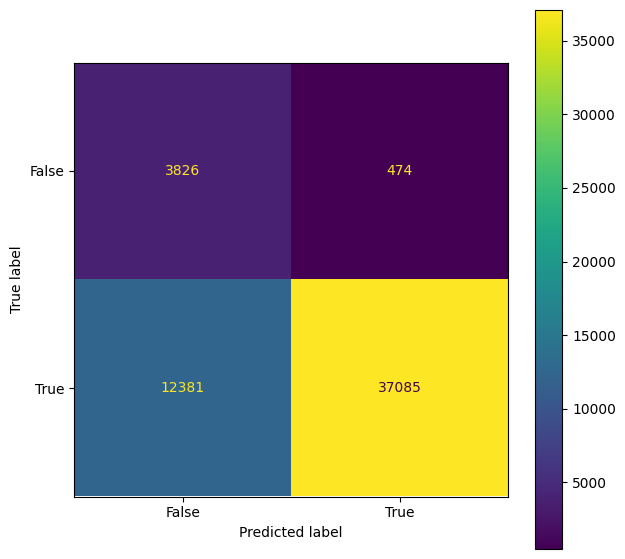

In [188]:
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(pred, Y_test_rating),\
    display_labels=clf.classes_)
disp.plot()
plt.show()

In [185]:
# Trains random forest classifier
start = time.time()
rfc_rating = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 10000, min_samples_split = 0.001)
rfc_rating.fit(X_train, Y_train_rating)
end = time.time()
print("Training time: {}min".format(round((end-start)/60,2)))

# Evaluates model on test set
pred_rfc = rfc_rating.predict(X_test)

print("Accuracy: {}%".format(round(rfc_rating.score(X_test, Y_test_rating)*100,2)))
print("Confusion Matrix")
print(confusion_matrix(pred_rfc, Y_test_rating))

Training time: 6.0min
Accuracy: 85.99%
Confusion Matrix
[[ 8970   298]
 [ 7237 37261]]


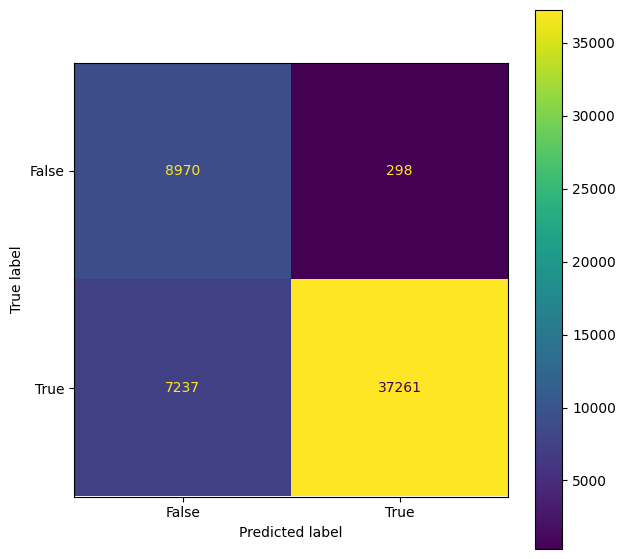

In [189]:
disp_2 = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(pred_rfc, Y_test_rating),\
    display_labels=rfc_rating.classes_)
disp_2.plot()
plt.show()

## Feature engineering 
- In order to improve the accuracy we decided to use the `textblob module` algorithm to get the sentiments of the reviews in `sentiment`column. 
- Then to use the LGBM `LIGHTGBM` algorithm to do the classification and compare the results with what we had until now.

In [215]:
def sentiment(review):
    # Sentiment polarity of the reviews
    pol = []
    for i in review:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

In [216]:
data_global["sentiment"]=sentiment(data_global['review'])

In [218]:
data_global["sentiment_clean"]=sentiment(data_global['review_clean_lem'])

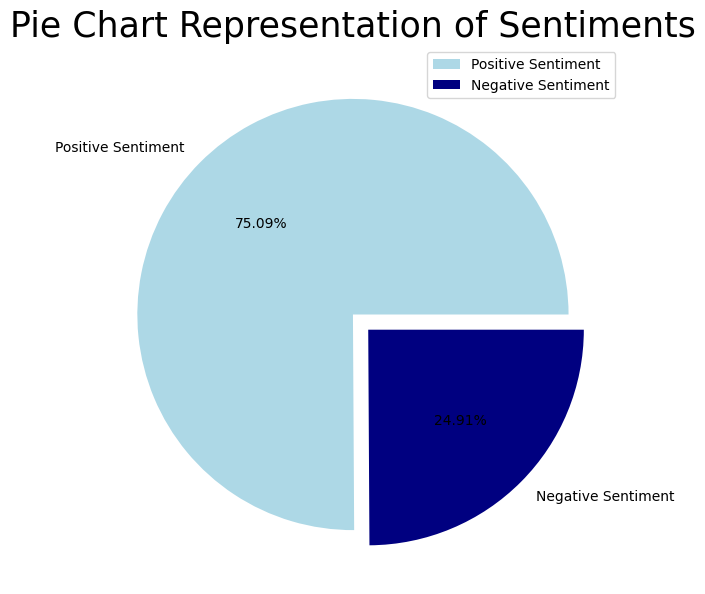

In [62]:
# a pie chart to represent the sentiments of the patients
size = data_global['Review_Sentiment'].value_counts().to_list()
colors = ['lightblue', 'navy']
labels = "Positive Sentiment","Negative Sentiment"
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size, colors = colors, labels = labels, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart Representation of Sentiments', fontsize = 25)
plt.legend()
plt.show()

In [224]:
data_global.loc[(data_global['rating'] >= 5), 'Review_Sentiment'] = 1
data_global.loc[(data_global['rating'] < 5), 'Review_Sentiment'] = 0

data_global['Review_Sentiment'].value_counts()

1.0    161491
0.0     53572
Name: Review_Sentiment, dtype: int64

The new features engineered are : 
- `count_word` which is the number of words in each review
-  `count_unique_word` which is the number of the unique words in the reviews. 
- `count_letters` is the letter count
-  `punctuation_count` is the punctuation count
-  `count_words_upper` is the upper case word count
- `count_words_title` is the title case word counts
- `count_stopwords` is the number of stop words in the review 
- `mean_word_len` is the average length of the words in the review.

In [223]:
import string
#Word count in each review
data_global['count_word']=data_global["review_clean_lem"].apply(lambda x: len(str(x).split()))

#Unique word count 
data_global['count_unique_word']=data_global["review_clean_lem"].apply(lambda x: len(set(str(x).split())))

#Letter count
data_global['count_letters']=data_global["review_clean_lem"].apply(lambda x: len(str(x)))

#punctuation count
data_global["count_punctuations"] = data_global["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
data_global["count_words_upper"] = data_global["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
data_global["count_words_title"] = data_global["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
data_global["count_stopwords"] = data_global["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

#Average length of the words
data_global["mean_word_len"] = data_global["review_clean_lem"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

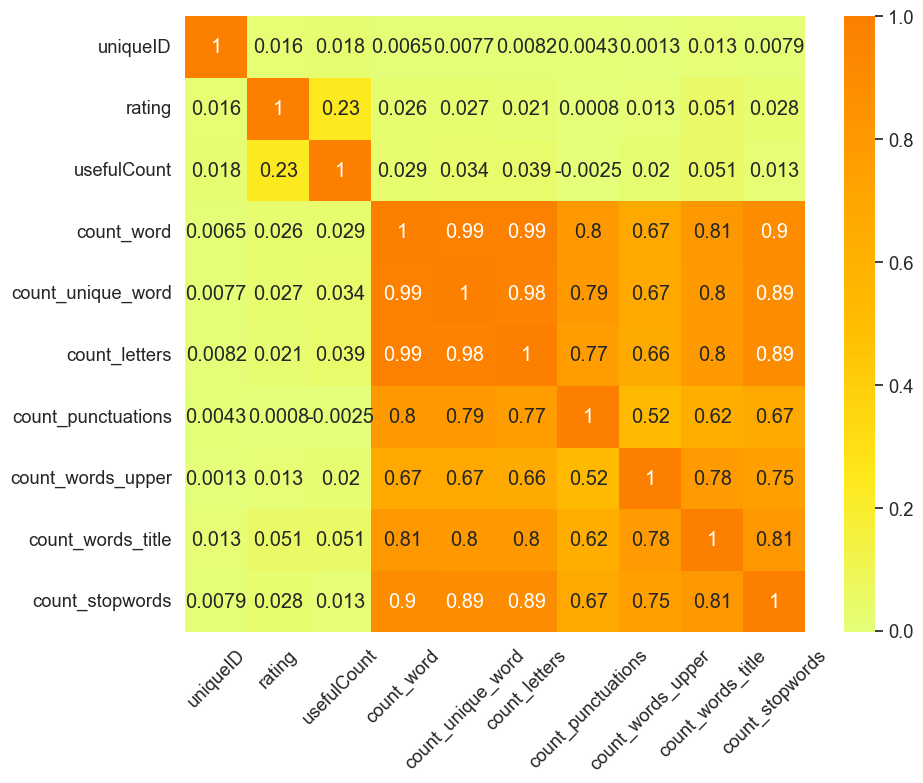

In [226]:
# Correlation Heatmap of the features engineered
plt.rcParams['figure.figsize'] = [10,8]
sns.set(font_scale = 1.2)
corr = data_global.select_dtypes(include = 'int64').corr()
sns_ = sns.heatmap(corr, annot = True, cmap = 'Wistia')
plt.setp(sns_.get_xticklabels(), rotation = 45);

In [228]:
# Label Encoding Drugname and Conditions
from sklearn.preprocessing import LabelEncoder
label_encoder_feat = {}
for feature in ['drugName', 'condition']:
    label_encoder_feat[feature] = LabelEncoder()
    data_global[feature] = label_encoder_feat[feature].fit_transform(data_global[feature])

To enable machine learning modeling, the Label Encoder is employed to convert the categorical values of Drug Names and conditions into numerical values. Due to the existence of 3,667 distinct drugs in the dataset, using a One hot encoder is not feasible as it would result in the creation of 3,667 new features, making it computationally costly.

In [243]:
# Defining Features and splitting the data as train and test set

features = data_global[['condition', 'usefulCount', 'sentiment',
                   'sentiment_clean', 'count_word', 'count_unique_word', 'count_letters',
                   'count_punctuations', 'count_words_upper', 'count_words_title',
                   'count_stopwords', 'mean_word_len']]

target = data_global['Review_Sentiment']

X_train_LGBM, X_test_LGBM, y_train_LGBM, y_test_LGBM = features.iloc[:161297], features.iloc[161297:], target[:161297], target[161297:]
print ("The Train set size ", X_train_LGBM.shape)
print ("The Test set size ", X_test_LGBM.shape)

The Train set size  (161297, 12)
The Test set size  (53766, 12)


In [245]:
# Training Model - I
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
model = clf.fit(X_train_LGBM, y_train_LGBM)

# Predictions
predictions_LGBM = model.predict(X_test_LGBM)
print ("The Accuracy of the model is : {}%".format(round(accuracy_score(y_test_LGBM, predictions_LGBM)*100,2)))
print ("The confusion Matrix is ")
confusion_matrix(y_test_LGBM, predictions_LGBM)

The Accuracy of the model is : 90.02%
The confusion Matrix is 


array([[ 9739,  3758],
       [ 1606, 38663]], dtype=int64)

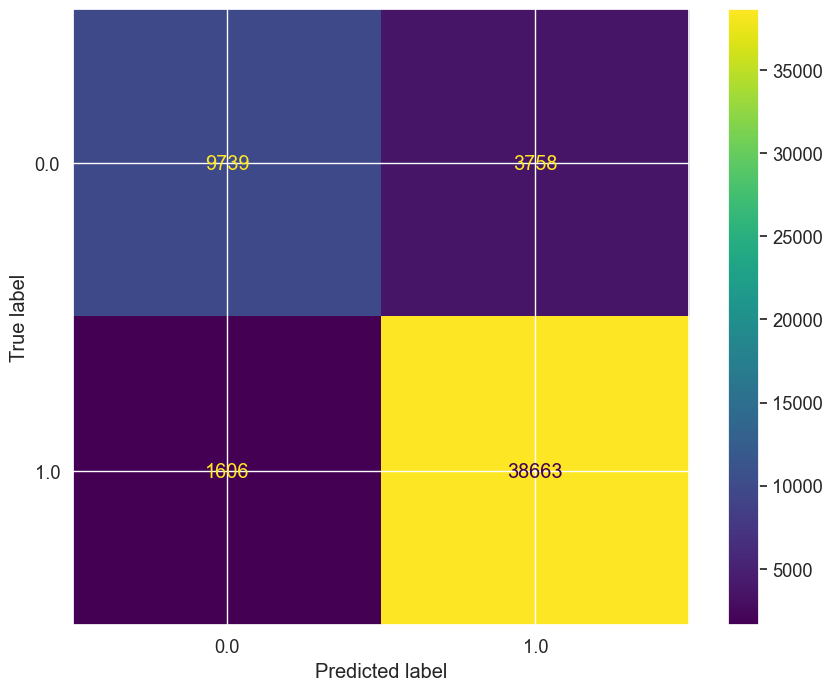

In [246]:
disp_2 = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test_LGBM, predictions_LGBM),\
    display_labels=model.classes_)
disp_2.plot()
plt.show()

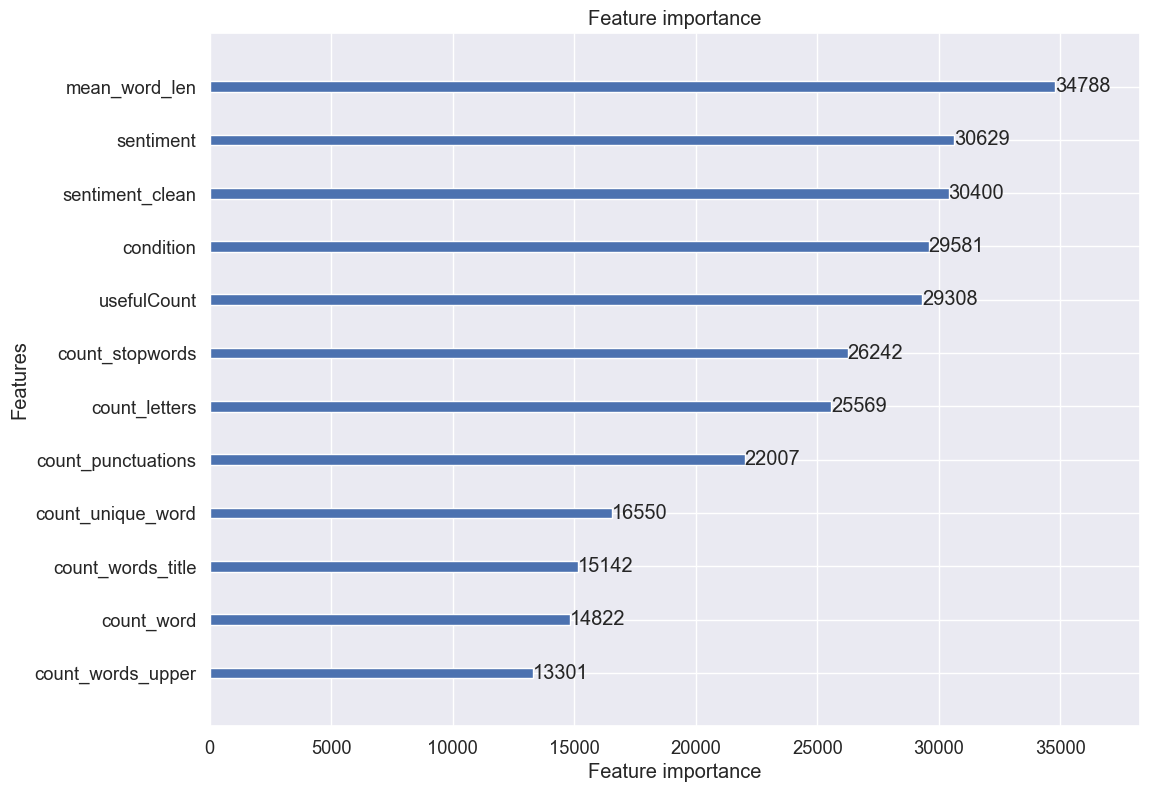

In [247]:
# Feature Importance Plot using LGBM
plt.rcParams['figure.figsize'] = [12, 9]
sns.set(style = 'darkgrid', font_scale = 1.2)
plot_importance(model);

# Conclusion : 
In conclusion, this project allowed us to apply different preprocessing techniques on textual data, through these treatments we could test several classification algorithms and improve the accuracy of the prediction after each iteration.